In [1]:
"""
Adapted from Track1/find.py
"""
import sys
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

In [4]:
print(HERE)
sys.path.insert(0, str(Path(HERE, "..")))  # kinship root
sys.path.insert(0, str(Path(HERE, "..", "rfiw2021")))  # rfiw2021 dir

/warley/dev/research/kinship/notebooks


In [5]:
from dataset import FIWPair  # noqa: E402
from Track1.models import Net  # noqa: E402
from Track1.utils import set_seed  # noqa: E402

In [6]:
def extract_embeddings(val_loader, model):
    embeddings = []
    kin_relations = []
    face1_fids = []
    face2_fids = []

    for face1, face2, kin_relation, face1_fid, face2_fid in tqdm(val_loader):
        with torch.no_grad():
            embeddings1 = model.encoder(face1.cuda()).cpu().numpy()
            embeddings2 = model.encoder(face2.cuda()).cpu().numpy()
            embeddings.append(np.mean([embeddings1, embeddings2], axis=0))
            kin_relations.extend(kin_relation)
            face1_fids.extend(face1_fid.cpu().numpy())
            face2_fids.extend(face2_fid.cpu().numpy())

    # Now, embeddings contain all the embeddings
    embeddings = np.vstack(embeddings)
    kin_relations = np.vstack(kin_relations)
    face1_fids = np.vstack(face1_fids)
    face2_fids = np.vstack(face2_fids)

    return embeddings, (kin_relations, face1_fids, face2_fids)

In [103]:
def calculate_embeddings_2d(embeddings, perplexity):
    # This function will calculate the 2D embeddings given the original embeddings and a perplexity value.
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=5000, verbose=1)
    return tsne.fit_transform(embeddings)


def get_indices(krs, f1fids, f2fids, label):
    # This function will get the indices for kin and non-kin relationships
    # given the `krs`, `f1fids`, and `f2fids` labels.
    idxs = [idx for idx, val in enumerate(krs) if val == label]
    kin_idxs = [idx for idx in idxs if f1fids[idx] == f2fids[idx]]
    nonkin_idxs = [idx for idx in idxs if f1fids[idx] != f2fids[idx]]
    return kin_idxs, nonkin_idxs


def plot_single_tsne(ax, embeddings_2d, kin_idxs, nonkin_idxs, f2fids, color, label):
    # This function will plot a single t-SNE plot given the 2D embeddings, indices, color, and label.
    if kin_idxs:
        ax.scatter(
            embeddings_2d[kin_idxs, 0], embeddings_2d[kin_idxs, 1], color=color, marker=".", label=f"{label} kin"
        )
    if nonkin_idxs:
        ax.scatter(
            embeddings_2d[nonkin_idxs, 0],
            embeddings_2d[nonkin_idxs, 1],
            color=color,
            marker="x",
            label=f"{label} non-kin",
        )
        # TODO: enable to disable
        # for idx in nonkin_idxs:
        #     # TODO: use f1fids if f2fids was used to filter the fid
        #     ax.text(embeddings_2d[idx, 0], embeddings_2d[idx, 1] - 1, f2fids[idx][0], fontsize=6)
    ax.legend()


def plot_embeddings(embeddings, labels, perplexities, plot_path: str = "", **kwargs):
    # This is the main function that calls the other functions to generate and plot the t-SNE plots.

    # Call filter_embeddings to get the embeddings and labels
    embeddings, labels = filter_embeddings(embeddings, labels, **kwargs)

    krs, f1fids, f2fids = labels

    # Print number of embeddings, number of unique kin relations, number of kin and non-kin relations
    # Consider kin relations: fs, gmgd, ms, gfgd, bb, md, fd, sibs, gmgs, gfgs, ss
    print(f"Number of embeddings: {len(embeddings)}")
    print(f"Number of unique kin relations: {len(np.unique(krs))}")
    for kr in np.unique(krs):
        kin_idxs, nonkin_idxs = get_indices(krs, f1fids, f2fids, kr)
        print(f"Number of {kr} kin relations: {len(kin_idxs)}")
        print(f"Number of {kr} non-kin relations: {len(nonkin_idxs)}")

    # Create a color map for kin relations: fs, gmgd, ms, gfgd, bb, md, fd, sibs, gmgs, gfgs, ss
    color_map = {
        "fs": "red",
        "gmgd": "orange",
        "ms": "darkred",
        "gfgd": "green",
        "bb": "blue",
        "md": "purple",
        "fd": "brown",
        "sibs": "pink",
        "gmgs": "gray",
        "gfgs": "olive",
        "ss": "cyan",
    }

    # Define n_subplots based on number of perplexity values
    n_subplots = len(perplexities)
    n_col = n_subplots // 2 if n_subplots > 1 else 1
    n_row = int(np.ceil(n_subplots / n_col))

    # Prepare a figure to hold the subplots
    fig, axes = plt.subplots(n_row, n_col, figsize=(5 * n_col, 5 * n_row))
    if n_subplots > 1:
        axes = axes.flatten()  # Flatten the axes array to make it easier to work with
    else:
        axes = [axes]

    # Generate and plot t-SNE for different perplexity values
    for i, perplexity in enumerate(perplexities):
        print(f"Generating t-SNE with perplexity={perplexity}")
        embeddings_2d = calculate_embeddings_2d(embeddings, perplexity)

        ax = axes[i]  # Get the current subplot

        # Plot
        for label, color in color_map.items():
            kin_idxs, nonkin_idxs = get_indices(krs, f1fids, f2fids, label)
            plot_single_tsne(ax, embeddings_2d, kin_idxs, nonkin_idxs, f2fids, color, label)

        ax.set_title(f"Perplexity: {perplexity}")

    plt.tight_layout()
    if plot_path:
        plt.savefig(plot_path)
    plt.show()

In [105]:
def filter_embeddings(embeddings, labels, kin_relation: list = [], face1_fid: list = [], face2_fid: list = []):
    kin_relations, face1_fids, face2_fids = labels

    idxs_kr = np.arange(len(kin_relations)).reshape(-1, 1)
    idxs_f1 = np.arange(len(face1_fids)).reshape(-1, 1)
    idxs_f2 = np.arange(len(face2_fids)).reshape(-1, 1)

    if kin_relation:
        idxs_kr = idxs_kr[np.isin(kin_relations, kin_relation)]
    if face1_fid:
        idxs_f1 = idxs_f1[np.isin(face1_fids, face1_fid)]
    if face2_fid:
        idxs_f2 = idxs_f2[np.isin(face2_fids, face2_fid)]

    idxs = np.intersect1d(idxs_kr, idxs_f1)
    idxs = np.intersect1d(idxs, idxs_f2)
    labels = (kin_relations[idxs], face1_fids[idxs], face2_fids[idxs])

    return embeddings[idxs], labels

In [9]:
def setup_data(root_dir, csv_path, batch_size, samples_per_member: int = 1):
    # Loading and sampling the dataset
    val_dataset = FIWPair(
        root_dir=root_dir, csv_path=csv_path, families=[250, 283, 409, 735, 873], samples_per_member=samples_per_member
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False)
    return val_loader

In [10]:
def setup_model(model_path):
    # Loading model
    model = Net().cuda()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    set_seed(100)

    return model

In [11]:
root_dir = Path(HERE, "../rfiw2021/Track1/")
csv_path = Path(HERE, "../rfiw2021/Track1/sample0/val.txt")
batch_size = 40
model_path = Path(HERE, "../rfiw2021/Track1/model_track1.pth")
plot_path = ""

In [12]:
model = setup_model(model_path)

In [20]:
val_loader = setup_data(root_dir, csv_path, batch_size)

Total samples: 100574


In [43]:
val_loader.dataset.sample_list[["kin_relation", "is_kin"]].groupby("is_kin").value_counts()

is_kin  kin_relation
0       fs              9399
        ms              8441
        md              7587
        fd              7575
        sibs            7068
        bb              4170
        ss              2991
        gfgs             879
        gfgd             762
        gmgd             714
        gmgs             701
1       fs              9399
        ms              8441
        md              7587
        fd              7575
        sibs            7068
        bb              4170
        ss              2991
        gfgs             879
        gfgd             762
        gmgd             714
        gmgs             701
Name: count, dtype: int64

In [69]:
# First create a DataFrame of 'fs' relations
fs_relations = sample_list[sample_list["kin_relation"] == "fs"]

# Group by 'face1_family_id' and 'face2_family_id', and count the number of 'fs' relations
fs_counts_face1 = fs_relations.groupby("face1_family_id").size()
fs_counts_face2 = fs_relations.groupby("face2_family_id").size()

# Calculate the proportion of 'fs' relations in each family
fs_proportions_face1 = fs_counts_face1 / len(fs_relations)
fs_proportions_face2 = fs_counts_face2 / len(fs_relations)

# Calculate and print the mean and standard deviation of the proportions
mean_face1 = fs_proportions_face1.mean()
std_face1 = fs_proportions_face1.std()
mean_face2 = fs_proportions_face2.mean()
std_face2 = fs_proportions_face2.std()

print(f"face1_family_id: Mean = {mean_face1}, Std = {std_face1}")
print(f"face2_family_id: Mean = {mean_face2}, Std = {std_face2}")

face1_family_id: Mean = 0.007407407407407408, Std = 0.007136621089833891
face2_family_id: Mean = 0.007407407407407408, Std = 0.007088373409469613


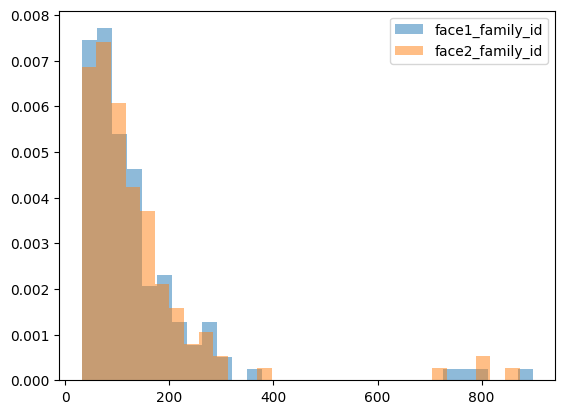

In [78]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure()

# Plot a histogram of fs_counts_face1
plt.hist(fs_counts_face1, bins=30, alpha=0.5, label="face1_family_id", density=True)

# Overlay a histogram of fs_counts_face2
plt.hist(fs_counts_face2, bins=30, alpha=0.5, label="face2_family_id", density=True)

# Add a legend to distinguish the two histograms
plt.legend(loc="upper right")

# Display the plot
plt.show()

In [85]:
# Group by 'face1_family_id', then get the value counts of 'face2_family_id' within each group
family_proportions = sample_list.groupby("face1_family_id")["face2_family_id"].value_counts(normalize=True)

family_proportions

face1_family_id  face2_family_id
7                7                  0.590376
                 873                0.024648
                 513                0.012911
                 990                0.009977
                 836                0.008216
                                      ...   
1004             617                0.009804
                 632                0.009804
                 633                0.009804
                 644                0.009804
                 7                  0.009804
Name: proportion, Length: 19226, dtype: float64

In [89]:
# Extracting embeddings
embeddings, labels = extract_embeddings(val_loader, model)

  0%|                                                                                                                                                                                                                                           | 0/2515 [00:00<?, ?it/s]/home/warley/.virtualenvs/rfiw2021/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2515/2515 [10:48<00:00,  3.88it/s]


Generating t-SNE with perplexity=10
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.000s...
[t-SNE] Computed neighbors for 113 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 5.513078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.793713
[t-SNE] KL divergence after 2750 iterations: 0.418845
Generating t-SNE with perplexity=30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.000s...
[t-SNE] Computed neighbors for 113 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 7.951740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.107510
[t-SNE] KL divergence after 900 iterations: 0.314130
Generating t-SNE with perplexity=60
[t-SNE] Computing 112 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.000s...
[t-SNE] Computed neighbors for 113 samples in 0.003s...
[t-SNE] Computed conditio

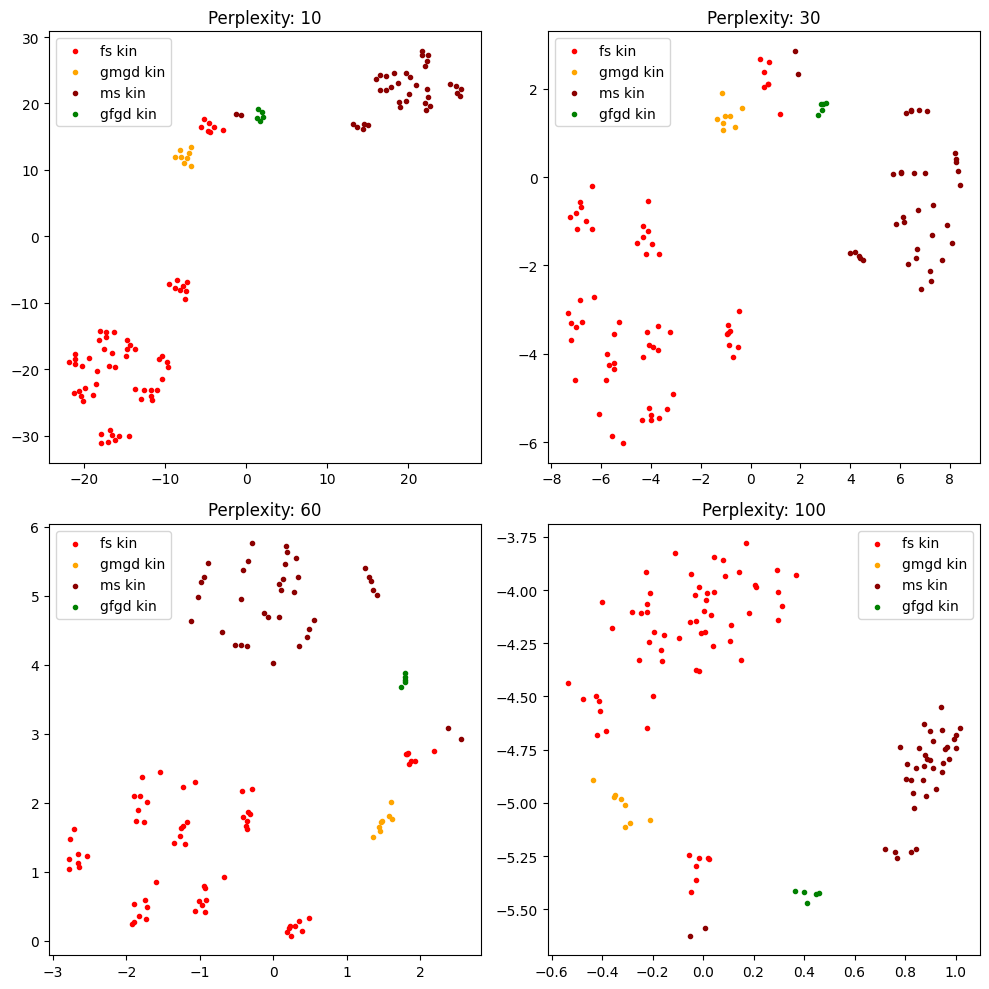

In [93]:
# Plotting
perplexities = [10, 30, 60, 100]
plot_embeddings(embeddings, labels, perplexities, face1_fid=250, face2_fid=250)

## Showing non kin pairs

Generating t-SNE with perplexity=10
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 264 samples in 0.000s...
[t-SNE] Computed neighbors for 264 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 264 / 264
[t-SNE] Mean sigma: 5.342529
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.513363
[t-SNE] KL divergence after 5000 iterations: 0.617586
Generating t-SNE with perplexity=30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 264 samples in 0.000s...
[t-SNE] Computed neighbors for 264 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 264 / 264
[t-SNE] Mean sigma: 7.187552
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.521858
[t-SNE] KL divergence after 1900 iterations: 0.522510
Generating t-SNE with perplexity=60
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 264 samples in 0.000s...
[t-SNE] Computed neighbors for 264 samples in 0.007s...
[t-SNE] Computed conditi

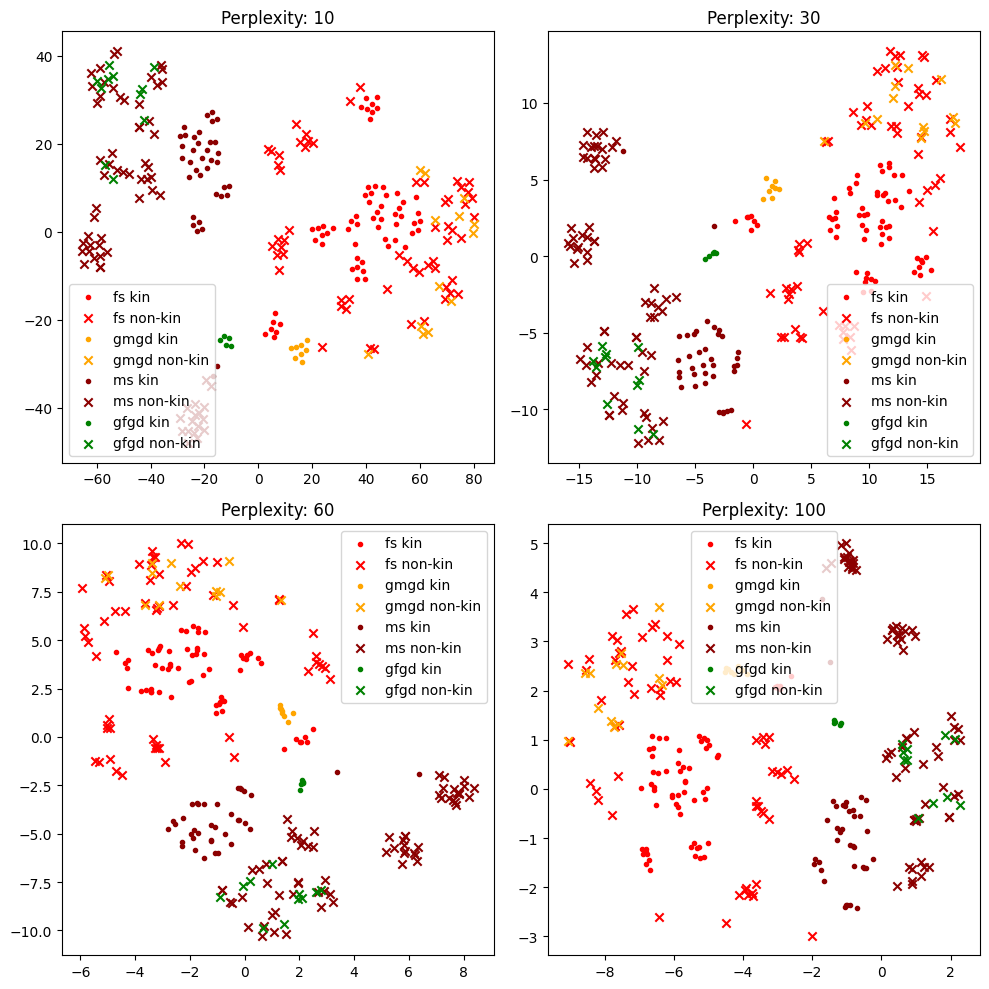

In [98]:
# Plotting
perplexities = [10, 30, 60, 100]
plot_embeddings(embeddings, labels, perplexities, face1_fid=250)

Generating t-SNE with perplexity=10
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 280 samples in 0.000s...
[t-SNE] Computed neighbors for 280 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 280 / 280
[t-SNE] Mean sigma: 4.543393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.681274
[t-SNE] KL divergence after 5000 iterations: 0.622734
Generating t-SNE with perplexity=30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 280 samples in 0.000s...
[t-SNE] Computed neighbors for 280 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 280 / 280
[t-SNE] Mean sigma: 5.857234
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.458138
[t-SNE] KL divergence after 2500 iterations: 0.536617
Generating t-SNE with perplexity=60
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 280 samples in 0.000s...
[t-SNE] Computed neighbors for 280 samples in 0.007s...
[t-SNE] Computed conditi

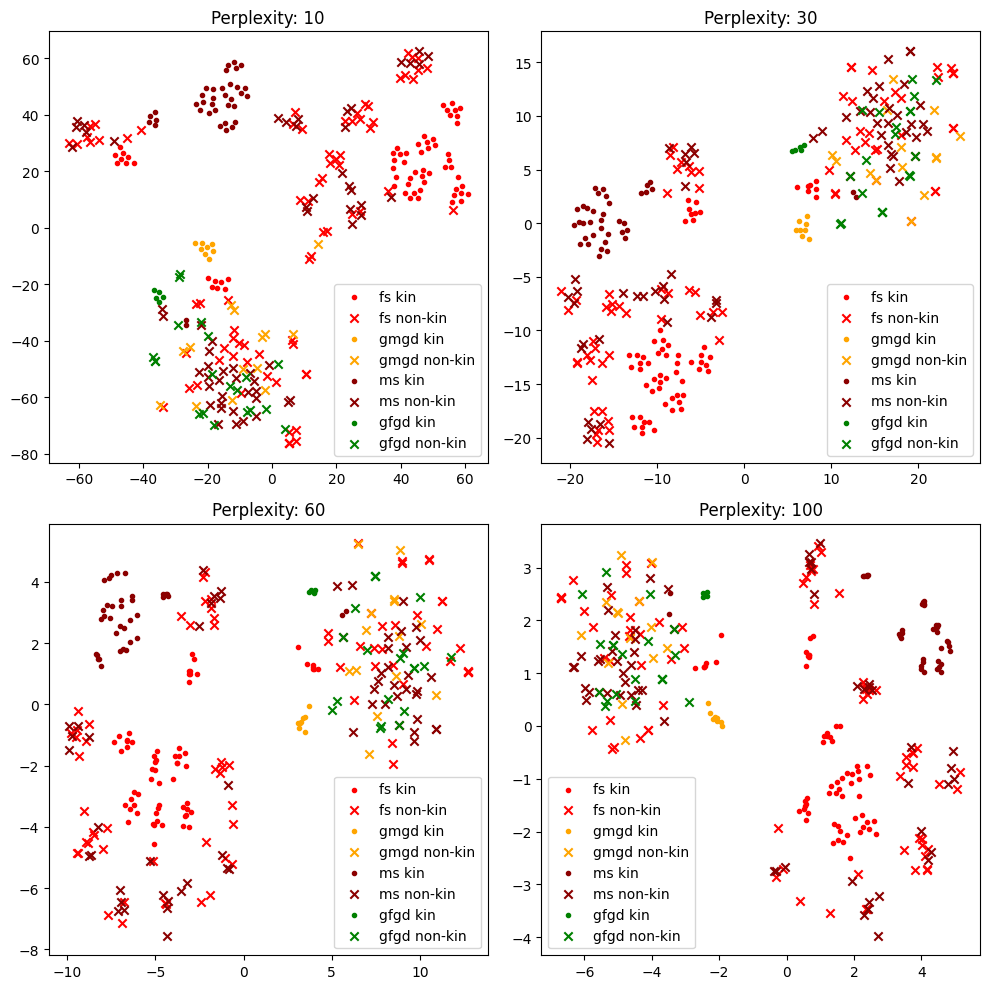

In [99]:
# Plotting
perplexities = [10, 30, 60, 100]
plot_embeddings(embeddings, labels, perplexities, face2_fid=250)

## Showing all pairs for kr = bb

Generating t-SNE with perplexity=10
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8340 samples in 0.001s...
[t-SNE] Computed neighbors for 8340 samples in 0.403s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8340
[t-SNE] Computed conditional probabilities for sample 2000 / 8340
[t-SNE] Computed conditional probabilities for sample 3000 / 8340
[t-SNE] Computed conditional probabilities for sample 4000 / 8340
[t-SNE] Computed conditional probabilities for sample 5000 / 8340
[t-SNE] Computed conditional probabilities for sample 6000 / 8340
[t-SNE] Computed conditional probabilities for sample 7000 / 8340
[t-SNE] Computed conditional probabilities for sample 8000 / 8340
[t-SNE] Computed conditional probabilities for sample 8340 / 8340
[t-SNE] Mean sigma: 3.967108
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.011200


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[t-SNE] KL divergence after 5000 iterations: 1.287940
Generating t-SNE with perplexity=30
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8340 samples in 0.001s...
[t-SNE] Computed neighbors for 8340 samples in 0.340s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8340
[t-SNE] Computed conditional probabilities for sample 2000 / 8340
[t-SNE] Computed conditional probabilities for sample 3000 / 8340
[t-SNE] Computed conditional probabilities for sample 4000 / 8340
[t-SNE] Computed conditional probabilities for sample 5000 / 8340
[t-SNE] Computed conditional probabilities for sample 6000 / 8340
[t-SNE] Computed conditional probabilities for sample 7000 / 8340
[t-SNE] Computed conditional probabilities for sample 8000 / 8340
[t-SNE] Computed conditional probabilities for sample 8340 / 8340
[t-SNE] Mean sigma: 5.269170
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.855362


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[t-SNE] KL divergence after 5000 iterations: 1.428045
Generating t-SNE with perplexity=60
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 8340 samples in 0.001s...
[t-SNE] Computed neighbors for 8340 samples in 0.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8340
[t-SNE] Computed conditional probabilities for sample 2000 / 8340
[t-SNE] Computed conditional probabilities for sample 3000 / 8340
[t-SNE] Computed conditional probabilities for sample 4000 / 8340
[t-SNE] Computed conditional probabilities for sample 5000 / 8340
[t-SNE] Computed conditional probabilities for sample 6000 / 8340
[t-SNE] Computed conditional probabilities for sample 7000 / 8340
[t-SNE] Computed conditional probabilities for sample 8000 / 8340
[t-SNE] Computed conditional probabilities for sample 8340 / 8340
[t-SNE] Mean sigma: 6.023148
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.831894


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[t-SNE] KL divergence after 5000 iterations: 1.459993
Generating t-SNE with perplexity=100
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 8340 samples in 0.001s...
[t-SNE] Computed neighbors for 8340 samples in 0.495s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8340
[t-SNE] Computed conditional probabilities for sample 2000 / 8340
[t-SNE] Computed conditional probabilities for sample 3000 / 8340
[t-SNE] Computed conditional probabilities for sample 4000 / 8340
[t-SNE] Computed conditional probabilities for sample 5000 / 8340
[t-SNE] Computed conditional probabilities for sample 6000 / 8340
[t-SNE] Computed conditional probabilities for sample 7000 / 8340
[t-SNE] Computed conditional probabilities for sample 8000 / 8340
[t-SNE] Computed conditional probabilities for sample 8340 / 8340
[t-SNE] Mean sigma: 6.578713
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.609879


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[t-SNE] KL divergence after 5000 iterations: 1.446427


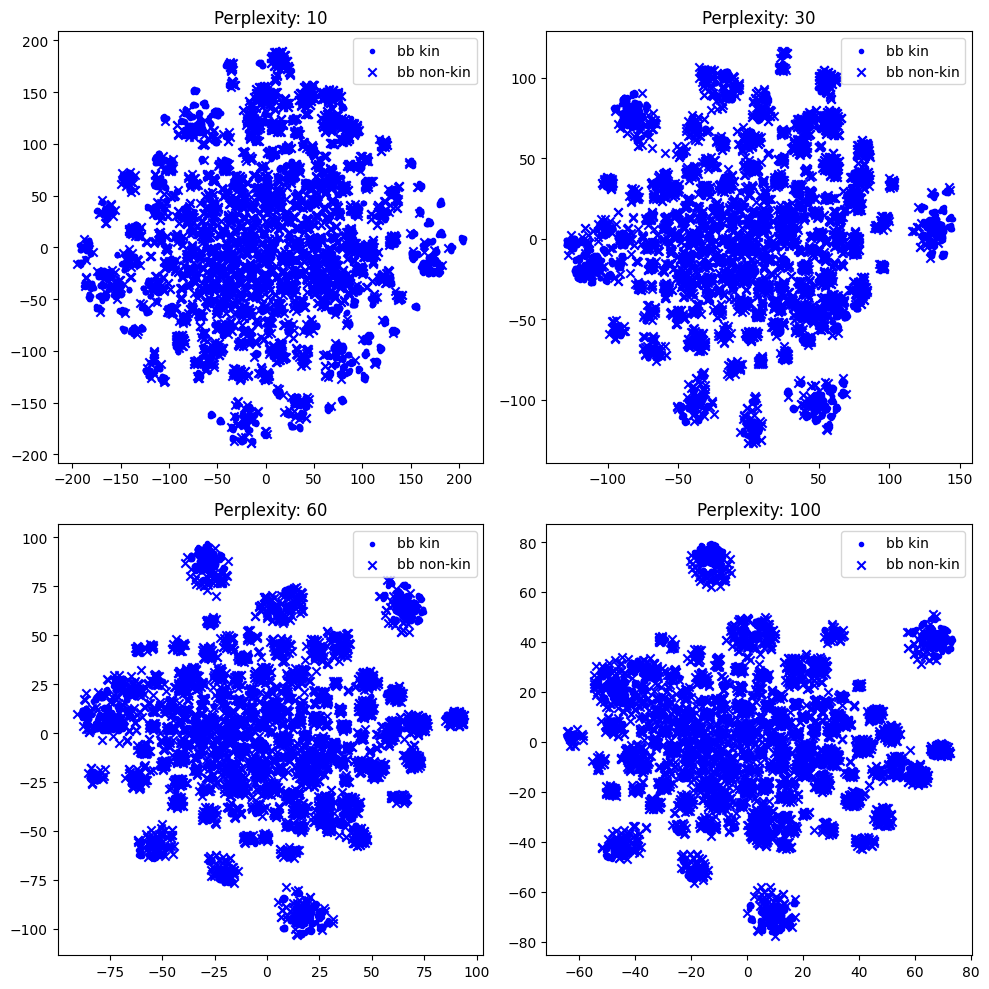

In [100]:
# Plotting
perplexities = [10, 30, 60, 100]
plot_embeddings(embeddings, labels, perplexities, kin_relation="bb")
# TODO: permit to change color to family instead kr

- Ploting non-kin seems to be useless. Note the previous plots: non-kin points are dispersed because they can come from any family pair (A and B, A and C, etc).
- This plot shows the same, but for all family pairs.

## Showing all pairs and kinship relations for two different families

- Hypothesis: pair embeddings are conditioned on the families. That is, pairs for A and B will be different from A and C. That seems obvious...

Number of embeddings: 872
Number of unique kin relations: 11
Number of bb kin relations: 21
Number of bb non-kin relations: 0
Number of fd kin relations: 130
Number of fd non-kin relations: 0
Number of fs kin relations: 107
Number of fs non-kin relations: 1
Number of gfgd kin relations: 17
Number of gfgd non-kin relations: 3
Number of gfgs kin relations: 48
Number of gfgs non-kin relations: 0
Number of gmgd kin relations: 17
Number of gmgd non-kin relations: 2
Number of gmgs kin relations: 25
Number of gmgs non-kin relations: 0
Number of md kin relations: 109
Number of md non-kin relations: 0
Number of ms kin relations: 72
Number of ms non-kin relations: 4
Number of sibs kin relations: 147
Number of sibs non-kin relations: 0
Number of ss kin relations: 169
Number of ss non-kin relations: 0
Generating t-SNE with perplexity=10
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 872 samples in 0.000s...
[t-SNE] Computed neighbors for 872 samples in 0.013s...
[t-SNE] Computed conditi

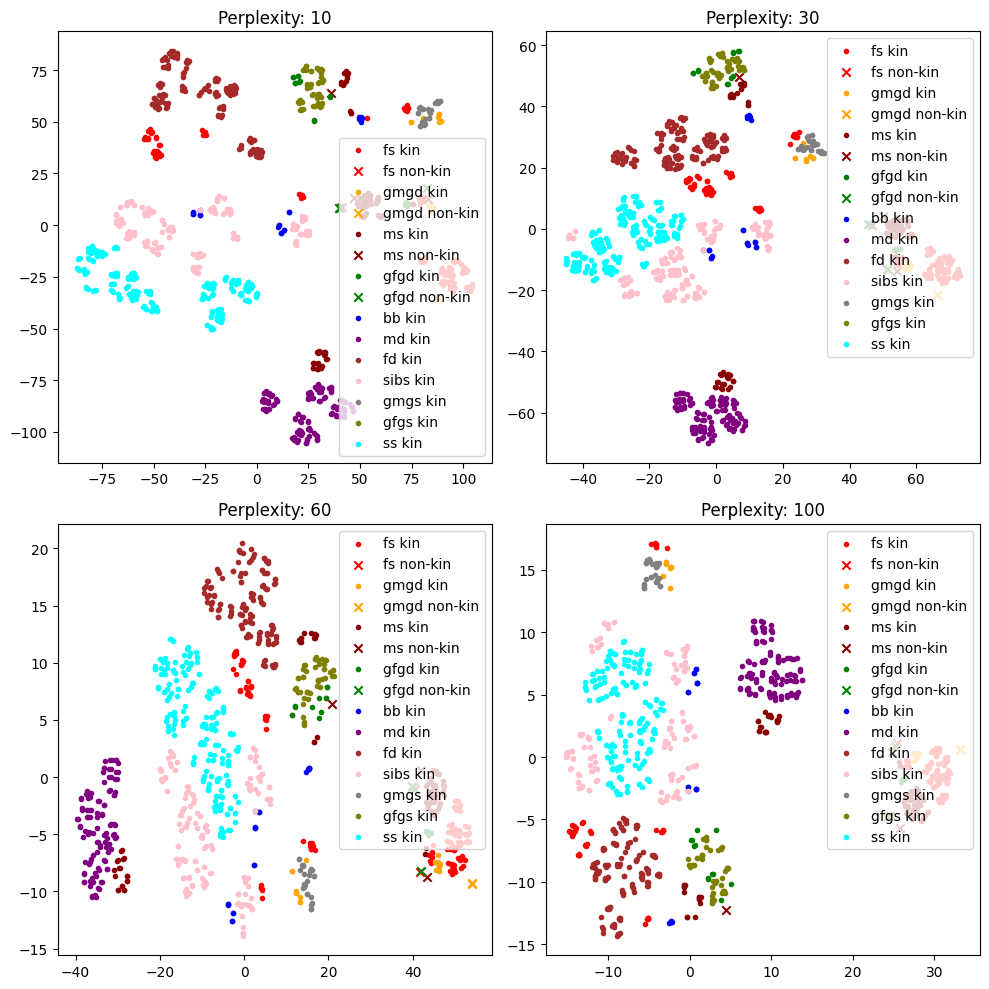

In [107]:
# Plotting
perplexities = [10, 30, 60, 100]
plot_embeddings(embeddings, labels, perplexities, face1_fid=[250, 873], face2_fid=[250, 873])
# TODO: how to change the plot to differentiate families?